In [68]:
import pandas as pd

import re

import os
import emoji
import time
import hashlib

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from math import exp

import numpy as np
from numpy import sign
import ftfy

import warnings
warnings.filterwarnings("ignore")

import ftfy
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

from twitterscraper.query import query_tweets, query_tweets_from_user

[nltk_data] Downloading package stopwords to C:\Users\venkata
[nltk_data]     pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\venkata pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [28]:
np.random.seed(1234)

Depression_Tweets = 5000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
Random_Tweets = 20000 # number of rows to read from RANDOM_TWEETS_CSV
Max_Tweet_Length = 280 # Max tweet size
Max_Unique_Words = 20000
Embedding_Dimension = 300
Train = 0.6
Test = 0.2
Learning_Rate = 0.1
EPOCHS= 10

In [29]:
Depression_Tweets_File = 'Depression_Tweets.csv'
Random_Tweets_File = 'Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [30]:
depressive_tweets_Data = pd.read_csv(Depression_Tweets_File, encoding = "ISO-8859-1", usecols = range(0,5), nrows =  Depression_Tweets)
random_tweets_Data = pd.read_csv(Random_Tweets_File, encoding = "ISO-8859-1", usecols = range(0,4), nrows = Random_Tweets)

In [31]:
depressive_tweets_Data.head()

,date,time,timezone,username,tweet
0,17/04/2019,18:46:06,Eastern Daylight Time,hilaryjhendel,âThe problem is no one can see my scars.â ...
1,17/04/2019,18:46:05,Eastern Daylight Time,chronicgamerguy,And due to what's going to happen later. My st...
2,17/04/2019,18:45:59,Eastern Daylight Time,jennnaglavin,My doctor continuously tells me not to drink c...
3,17/04/2019,18:45:49,Eastern Daylight Time,amelia_kathleen,âAnXIetY IsNT ReALâ
4,17/04/2019,18:45:46,Eastern Daylight Time,moharris92,Itâs been so long since Iâve watched any T...


In [32]:
random_tweets_Data.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [33]:

#import en_core_web_sm
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                    "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                    "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would",
                    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have","today's": "today is","tomorrow's":"tomorrow is", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have","&amp;":"and","&lt;":"<","&gt;":">","&le;":"=<","&ge;":">="}
stop_words=set(stopwords.words('english'))


In [34]:

def removestopwords(line):
    words=word_tokenize(line)
    wordslist=[]
    for word in words:
            if not word in stop_words:
                wordslist.append(word)
    return ' '.join(wordslist)           

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:                    
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))    
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)

    res_words = []
    for word, tag in wn_tagged:
        if tag is None:                        
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))

    return ' '.join(res_words)

def removeUnnecessaryWords(x):
    words=x.split()
    for word in words:
            if not len(word)>1:
               words.remove(word) 
    if len(words)>1:
        return ' '.join(words)
    else:
        return ""

In [35]:
def clean_tweets(tweets):
    
    cleaned_tweets = []
    for tweet in tweets:
        x=tweet.lower()
        x=replace_contractions(x)                            
        #x=remove_nameentity(x)
        #remove urls
        x = re.sub(r'(via:)? +https?:\/\/.*,', ',', x)
        #remove datetime
        x=re.sub(r'\d+:?(\d+)?( +)?([ap]m):?( +([ce]dt)?)?',' ',x)
        #x=re.sub(r'cdt +',' ',x)
        x=re.sub(r'\d{4}-\d{2}-\d{2} +\d{2}:\d{2}:\d{2},', '', x)
        #remove temperature
        x=re.sub(r'\d+\/\d+°?[cf]',' ',x)
        #remove numbers
        x=re.sub(r'[0-9]*,?','',x)
        #remove floating point numbers
        x=re.sub(r'-?[0-9]*\.[0-9]*,?',' ',x)
        #remove hashtags and user tags
        x=re.sub(r'[#@]( +)?[a-zA-Z0-9.,_:]+','',x)
        #remove special characters
        x=re.sub(r'[:-?;&)(!"*%_+$~/\[\]]','',x)
        #remove emoji's
        x=emoji.get_emoji_regexp().sub(u'', x)
        #replace contraction with acutal words                      
        x=removestopwords(x)
        x=lemmatize_sentence(x)
        x=re.sub(r'\'s','',x)                            
        #removing non word characters and extra spaces in sentence
        x=re.sub(r'[^\w]', ' ', x)
        x=re.sub(r'[^a-zA-Z0-9]',' ',x)
        x=re.sub(r' +',' ',x)
        #removing white space characters
        x=re.sub(r' +[a-zA-Z] +','',x)
        x=x.strip()
        #x=' '.join()
        x=removeUnnecessaryWords(x)
        cleaned_tweets.append(x)

    return cleaned_tweets

In [36]:
depressive_tweets_arr = [x for x in depressive_tweets_df['tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\venkata
[nltk_data]     pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:

Depressive_Tweets_Cleaned = clean_tweets(depressive_tweets_arr)
Random_Tweets_Cleaned = clean_tweets(random_tweets_arr)

In [39]:
random_tweets_arr[1]

'                   I missed the New Moon trailer...'

In [40]:
Depressive_Tweets_Cleaned[0]

'the problem one see scar know intuitively depression anxiety deep seated insecurity wound stem verbal abusewish beaten marta share one occasiond feel legitimate httpswww hilaryjacobshendel comsingle postthe problem with yelling pic twitter comhcevsawrc'

In [42]:
tokenizer = Tokenizer(num_words=Max_Unique_Words)
print(tokenizer)

In [44]:
tokenizer.fit_on_texts(Depressive_Tweets_Cleaned + Random_Tweets_Cleaned)


In [45]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [46]:
Depressive_Tweets_vectors = tokenizer.texts_to_sequences(Depressive_Tweets_Cleaned)
Random_Tweets_vectors = tokenizer.texts_to_sequences(Random_Tweets_Cleaned)

In [47]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 32056 unique tokens


In [48]:
data_depressive_tweets = pad_sequences(Depressive_Tweets_vectors, maxlen=Max_Tweet_Length)
data_random_tweets = pad_sequences(Random_Tweets_vectors, maxlen=Max_Tweet_Length)
print('Shape of data_d tensor:', data_depressive_tweets.shape)
print('Shape of data_r tensor:', data_random_tweets.shape)

Shape of data_d tensor: (5000, 280)
Shape of data_r tensor: (20000, 280)


In [49]:
Frequent_Words = min(Max_Unique_Words, len(word_index))
print(EMBEDDING_DIM)

300


In [50]:
embedding_matrix = np.zeros((Frequent_Words, EMBEDDING_DIM))

In [51]:
print(Frequent_Words)

20000


In [52]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


In [54]:
for (word, index) in word_index.items():
    if word in word2vec.vocab and index < Max_Unique_Words:
        embedding_matrix[index-1] = word2vec.word_vec(word)

In [61]:
labels_d = np.array([1] * Depression_Tweets)
labels_r = np.array([0] * Random_Tweets)
print(labels_d)
print(labels_r)
perm_d = np.random.permutation(len(data_depressive_tweets))
print(perm_d)

idx_train_d = perm_d[:int(len(data_depressive_tweets)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_depressive_tweets)*(TRAIN_SPLIT)):int(len(data_depressive_tweets)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_depressive_tweets)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_random_tweets))
idx_train_r = perm_r[:int(len(data_random_tweets)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_random_tweets)*(TRAIN_SPLIT)):int(len(data_random_tweets)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_random_tweets)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_depressive_tweets[idx_train_d], data_random_tweets[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_depressive_tweets[idx_test_d], data_random_tweets[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_depressive_tweets[idx_val_d], data_random_tweets[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1536  704 1943 ... 3089 1070 4882]


In [62]:
EMBEDDING_DIM

300

In [63]:
model = Sequential()
# Embedded layer
model.add(Embedding(20000, 300,weights=[embedding_matrix], 
                            input_length=Max_Tweet_Length, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [64]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 140, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total para

In [65]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('model_new.hdf5', 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='min')
hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[checkpoint, early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 5000 samples
Epoch 1/10
15000/15000 [==============================] - 96s 6ms/step - loss: 0.2884 - acc: 0.8907 - val_loss: 0.1821 - val_acc: 0.9436

Epoch 00001: val_loss improved from inf to 0.18206, saving model to model_new.hdf5
Epoch 2/10
15000/15000 [==============================] - 92s 6ms/step - loss: 0.1748 - acc: 0.9406 - val_loss: 0.1625 - val_acc: 0.9470

Epoch 00002: val_loss improved from 0.18206 to 0.16250, saving model to model_new.hdf5
Epoch 3/10
15000/15000 [==============================] - 91s 6ms/step - loss: 0.1471 - acc: 0.9511 - val_loss: 0.1655 - val_acc: 0.9488

Epoch 00003: val_loss did not improve from 0.16250
Epoch 4/10
15000/15000 [==============================] - 90s 6ms/step - loss: 0.1272 - acc: 0.9563 - val_loss: 0.1764 - val_acc: 0.9462

Epoch 00004: val_loss did not improve from 0.16250
Epoch 5/10
15000/15000 [==============================] - 91s 6ms/step - loss: 

In [79]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 94.64%


In [79]:
list_of_tweets = query_tweets_from_user("@liz_ngx")

tweetsOfUser = [];

for tw in list_of_tweets:
    tweetsOfUser.append(tw.text)

INFO: Got 63 tweets from username @liz_ngx


In [80]:
Cleaned_User_Tweets = clean_tweets(tweetsOfUser)

In [81]:
Cleaned_User_Tweets

['post concert depression really hit hard twitter comojqbojpy',
 'rosie angelll felt like dyinggg twitter comtlhtl',
 'jennie cuteee omgggg twitter commdaydgs',
 'jisoo grab phone wtf poor baby get scared twitter comwtpoaetx',
 'omygod harry style really blackpink concert wtf wtf twitter comrmxswixruj',
 'need unprovoked attackhttpstwitter comcutecherrybitchstatus',
 'quiet public space stranger stomachpic twitter comnsdxdixegu',
 'wow may hardest coat ever see httpstwitter comthabostatus',
 'pic twitter comsxwfpqgyh',
 'make coachella look like blackpink concertpic twitter comujunrzjs',
 'pic twitter comwhhjoitgj',
 'pic twitter compjixqc',
 'yr ago today single thing could ever dopic twitter comyswekoqsjb',
 'oh gosh videoing baby bad dream watch sister pic twitter comacerrik',
 'saw adult german shepard diagnose dwarfism today cut thing saw yearpic twitter comfjijaaxwc',
 'bruh dog face yo lmfaoooo pic twitter comvqqmcfgj',
 'hummingbird drink nectar slow motion accidentally slap he

In [82]:
sequences_user = tokenizer.texts_to_sequences(Cleaned_User_Tweets)

In [83]:
sequences_user

[[234, 560, 174, 29, 265, 185, 13],
 [5305, 548, 5, 13],
 [19853, 13],
 [2266, 128, 478, 266, 116, 1, 1690, 13],
 [883, 923, 29, 560, 478, 478, 13],
 [25, 11975],
 [1201, 944, 767, 1685, 13],
 [314, 175, 8196, 9541, 82, 21, 69],
 [37, 13],
 [9, 3806, 40, 5, 13],
 [37, 13],
 [37, 13],
 [846, 373, 20, 454, 42, 55, 82, 13],
 [45, 1137, 116, 38, 282, 46, 393, 37, 13],
 [325, 1471, 3604, 1147, 20, 456, 42, 325, 13],
 [3655, 340, 197, 539, 37, 13],
 [395, 18009, 598, 3317, 2958, 3472, 418, 2515, 13],
 [3443, 1422, 78, 13],
 [67,
  32,
  1383,
  5884,
  16,
  620,
  1788,
  2652,
  67,
  484,
  572,
  141,
  78,
  19,
  315,
  5491,
  161,
  339,
  67,
  15,
  37,
  13],
 [2286, 871, 729, 433, 446, 37, 13],
 [2282, 392, 4456, 1101, 88, 13],
 [3121, 13],
 [19, 18579, 143, 195, 13],
 [537, 6965, 3086, 17419, 24],
 [340, 218, 13],
 [405, 3367, 69],
 [1173, 27, 13],
 [13],
 [194, 2261, 13],
 [860, 9553, 60, 13],
 [13],
 [11, 13],
 [4182, 13],
 [4209,
  4282,
  269,
  2231,
  27,
  2471,
  40,
  5

In [84]:
user_tweets = pad_sequences(sequences_user, maxlen=MAX_SEQUENCE_LENGTH)
user_tweets_labels_predicted = model.predict(user_tweets)
user_tweets_labels = np.round(user_tweets_labels_predicted.flatten())
user_tweets_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.], dtype=float32)

In [85]:
numberOfTweets = len(user_tweets)
print(numberOfTweets)
numberOfDepressiveTweets = 0

63


In [86]:
for tw_lab in user_tweets_labels:
    if(tw_lab>0):
        numberOfDepressiveTweets = numberOfDepressiveTweets+1

In [87]:
print(numberOfDepressiveTweets)

18


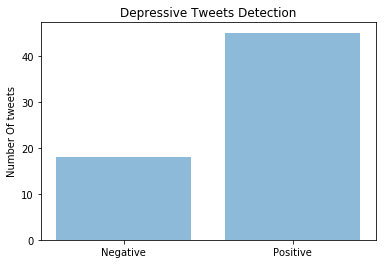

In [88]:
objects = ('Negative', 'Positive')
y_pos = np.arange(len(objects))
Results = [numberOfDepressiveTweets,numberOfTweets-numberOfDepressiveTweets]
 
plt.bar(y_pos, Results, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number Of tweets')
plt.title('Depressive Tweets Detection')
 
plt.show()